In [2]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__}"
)

Training on cpu using PyTorch 2.2.1+cu121


#Load data from Google Drive

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

BATCH_SIZE = 10  # batch size

def load_datasets():
    # Define the path to your dataset on Google Drive
    google_drive_path = "/content/drive/MyDrive/CSE707/dataset/Dataset_Equal_Image"

    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    # Load the custom dataset
    custom_dataset = ImageFolder(root=google_drive_path, transform=transform)

    # Split the dataset into training, validation, and test sets
    train_size = int(0.8 * len(custom_dataset))
    val_size = (len(custom_dataset) - train_size) // 2
    test_size = len(custom_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

    # Create DataLoader for training, validation, and test sets
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Print the number of classes and samples
    num_classes = len(custom_dataset.classes)
    print(f"Number of classes: {num_classes}")
    print(f"Class labels: {custom_dataset.classes}")
    print(f"Number of samples: {len(custom_dataset)}")

    return trainloader, valloader, testloader

# Load datasets
trainloader, valloader, testloader = load_datasets()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of classes: 3
Class labels: ['benign', 'malignant', 'normal']
Number of samples: 1350


In [4]:
# Assuming you have already loaded the data using load_datasets
trainloader, _, _ = load_datasets()  # Adjust if you have a validation loader

# Access the original dataset from the Subset
original_dataset = trainloader.dataset.dataset  # Note the double .dataset

# Get a batch of images and labels
images, labels = next(iter(trainloader))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(original_dataset.classes[labels[i]])  # Use original_dataset.classes
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()


Number of classes: 3
Class labels: ['benign', 'malignant', 'normal']
Number of samples: 1350


In [1]:
# # Get the class labels and counts
# class_labels = original_dataset.classes
# class_counts = [0] * len(class_labels)

# # Count the number of samples for each class
# for _, label in original_dataset:
#     class_counts[label] += 1

# # Plot the class distribution
# plt.figure(figsize=(10, 5))
# sns.barplot(x=class_labels, y=class_counts)
# plt.title('Class Distribution')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.show()


#Defining the model#



In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# Define the modified CustomNet with residual blocks
class CustomNet(nn.Module):
    def __init__(self, num_classes=3) -> None:
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.residual_block1 = ResidualBlock(16, 16)
        self.residual_block2 = ResidualBlock(16, 32, stride=2)
        self.residual_block3 = ResidualBlock(32, 64, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)  # Adding dropout

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.residual_block3(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Adding dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def calculate_final_size_after_conv(conv_layer, input_size):
    # Assuming 'conv_layer' is an instance of nn.Conv2d
    # Calculate the final size after applying the convolution
    with torch.no_grad():
        x = torch.zeros(1, 1, *input_size)  # Use 1 channel for grayscale
        y = conv_layer(x)
    return y.size(-1)


** Training and test functions**

In [6]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy


**Training the model**

Number of classes: 3
Class labels: ['benign', 'malignant', 'normal']
Number of samples: 1350
Epoch 1: Train Loss 0.0951, Train Accuracy 0.5333, Validation Loss 0.0965, Validation Accuracy 0.5630
Epoch 2: Train Loss 0.0878, Train Accuracy 0.6213, Validation Loss 0.0848, Validation Accuracy 0.6593
Epoch 3: Train Loss 0.0659, Train Accuracy 0.7481, Validation Loss 0.0654, Validation Accuracy 0.7778
Epoch 4: Train Loss 0.0977, Train Accuracy 0.6093, Validation Loss 0.0936, Validation Accuracy 0.6148
Epoch 5: Train Loss 0.0876, Train Accuracy 0.6491, Validation Loss 0.0834, Validation Accuracy 0.6370
Epoch 6: Train Loss 0.0371, Train Accuracy 0.8648, Validation Loss 0.0435, Validation Accuracy 0.8296
Epoch 7: Train Loss 0.0356, Train Accuracy 0.8722, Validation Loss 0.0457, Validation Accuracy 0.8074
Epoch 8: Train Loss 0.0286, Train Accuracy 0.8843, Validation Loss 0.0481, Validation Accuracy 0.8296
Epoch 9: Train Loss 0.0230, Train Accuracy 0.9407, Validation Loss 0.0389, Validation Accur

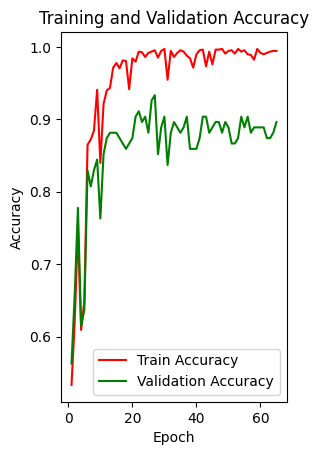

In [9]:
# Assuming you have already loaded the data using load_datasets
trainloader, valloader, testloader = load_datasets()  # Adjust if you have a validation loader
net = CustomNet().to(DEVICE)  # Assuming you have defined CustomNet

# Training loop
epochs = 65  # Increase the number of epochs
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []

# best_val_loss = np.inf
# patience = 3  # Number of epochs to wait before early stopping

for epoch in range(epochs):
    train(net, trainloader, 1)

    # Evaluate on validation set
    val_loss, val_accuracy = test(net, valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Evaluate on training set
    train_loss, train_accuracy = test(net, trainloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print training, validation, and test accuracy
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_accuracy:.4f}, Validation Loss {val_loss:.4f}, Validation Accuracy {val_accuracy:.4f}")


# # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping...")
#             break


# Evaluate on the test set
test_loss, test_accuracy = test(net, testloader)

print(f"Final Train set performance:\n\tLoss: {train_loss:.4f}\n\tAccuracy: {train_accuracy:.4f}")
print(f"Final Test set performance:\n\tLoss: {test_loss:.4f}\n\tAccuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_accuracies, 'r' , label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'r', label='Train Loss')
plt.plot(epochs_range, val_losses, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Convert accuracy to percentage
train_accuracy_percentage = train_accuracy
test_accuracy_percentage = test_accuracy

print(f"Final Train set performance:\n\tLoss: {train_loss:.4f}\n\tAccuracy: {train_accuracy_percentage:.4f}")
print(f"Final Test set performance:\n\tLoss: {test_loss:.4f}\n\tAccuracy: {test_accuracy_percentage:.4f}")


Final Train set performance:
	Loss: 0.0080
	Accuracy: 0.9944
Final Test set performance:
	Loss: 0.0315
	Accuracy: 0.9185


#Plot accuracy

**Confusion Matrix**

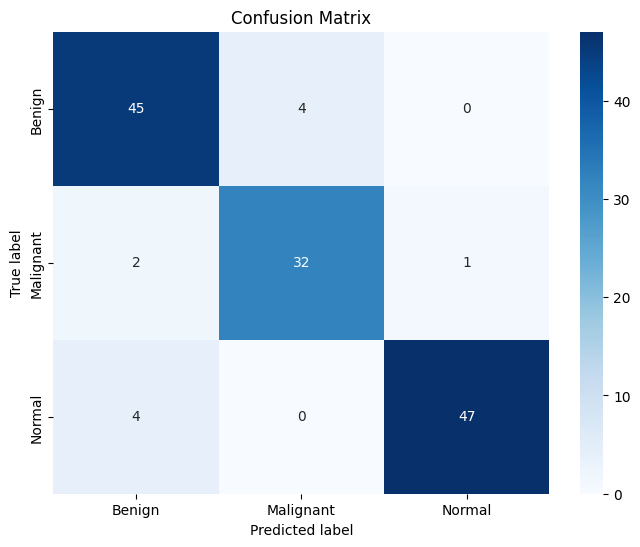

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Generate confusion matrix
true_labels = []
predicted_labels = []

net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

class_names = ['Benign', 'Malignant', 'Normal']


# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Display confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



In [12]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

      Benign       0.88      0.92      0.90        49
   Malignant       0.89      0.91      0.90        35
      Normal       0.98      0.92      0.95        51

    accuracy                           0.92       135
   macro avg       0.92      0.92      0.92       135
weighted avg       0.92      0.92      0.92       135



#Classify Image

In [14]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


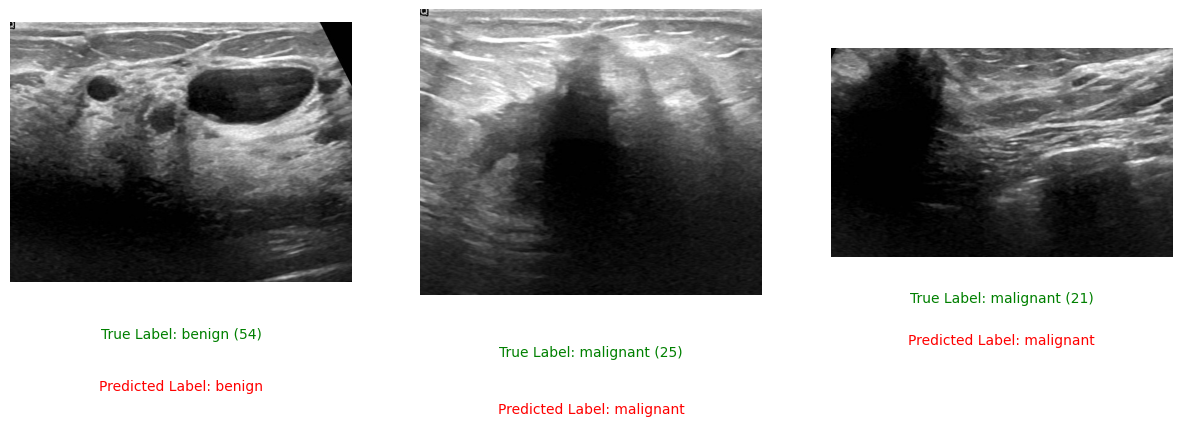

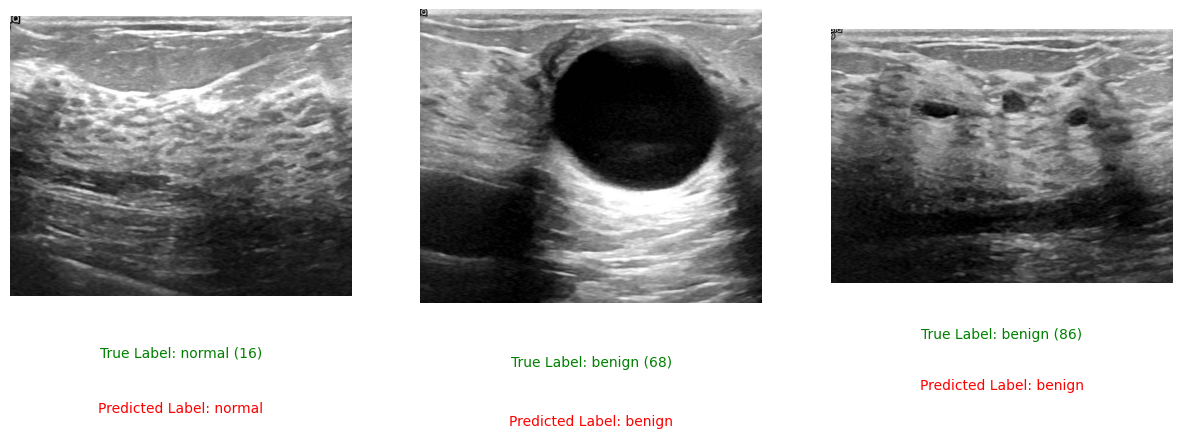

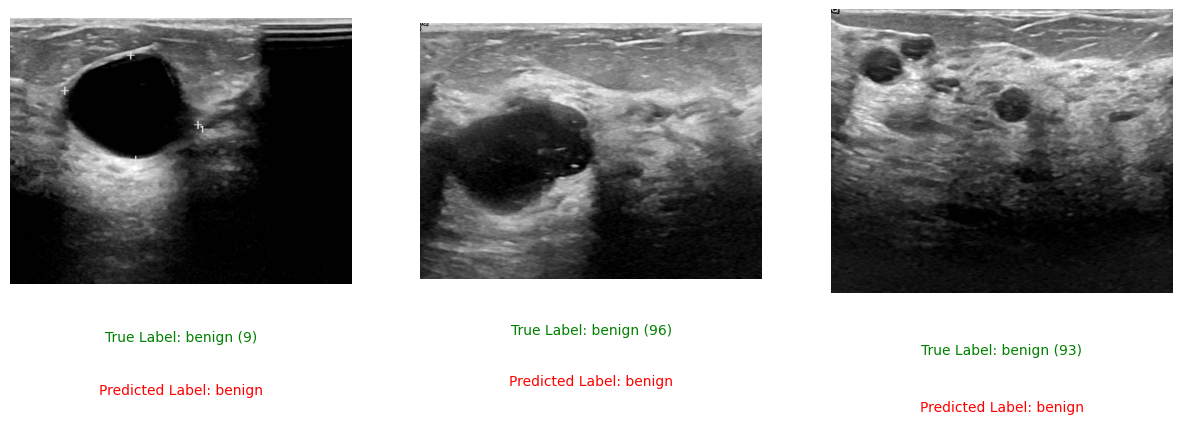

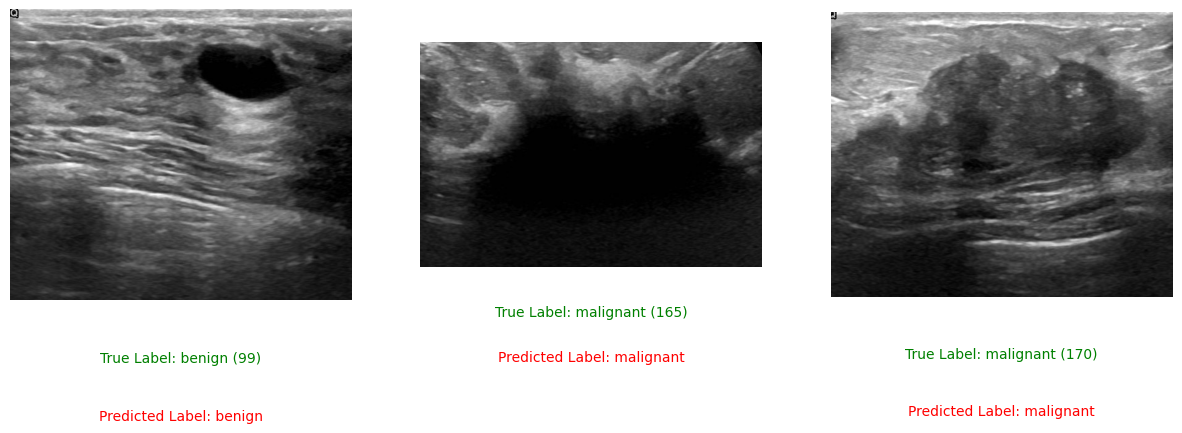

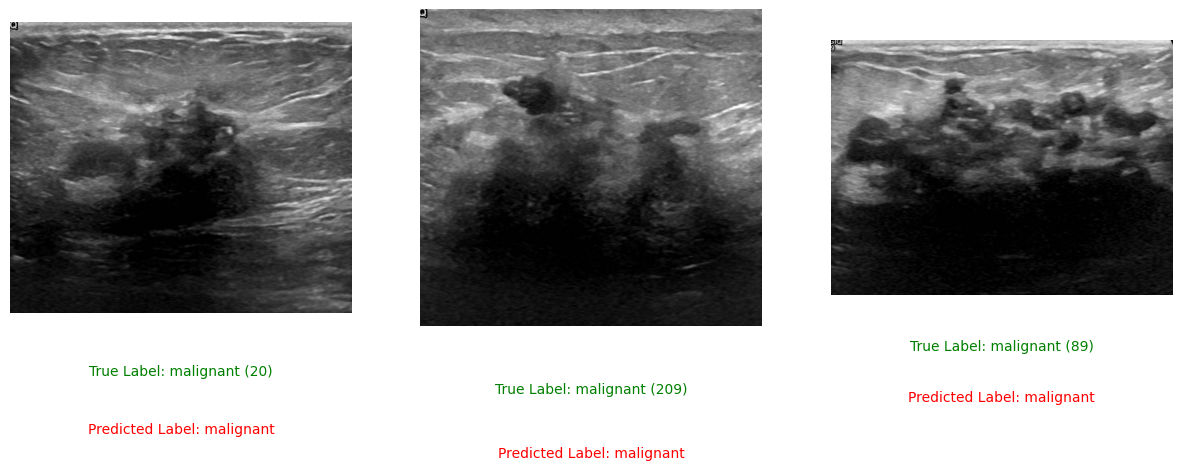

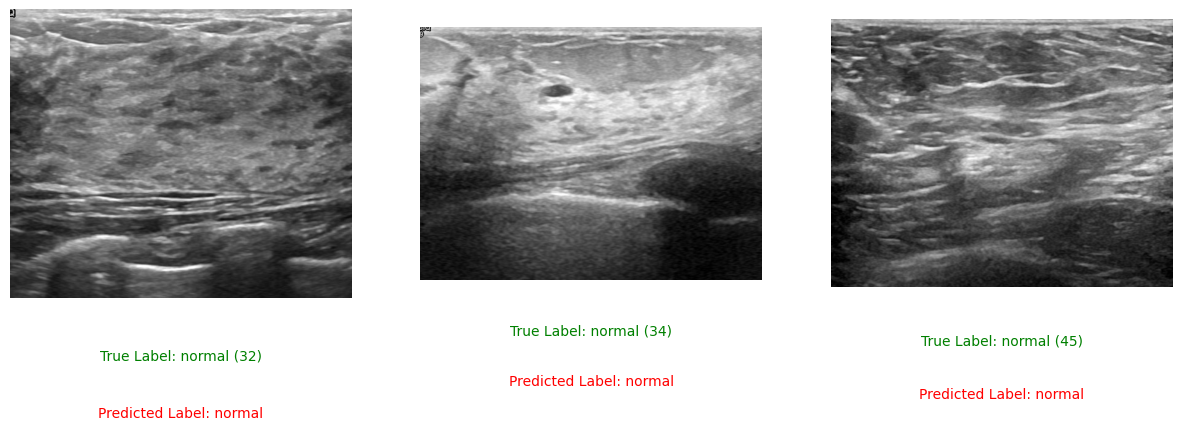

In [15]:
import os
from PIL import Image

directory_path = "/content/drive/MyDrive/CSE707/dataset/classify"
image_paths_to_classify = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Set the number of images per block
images_per_block = 3

# Calculate the number of blocks needed
num_blocks = len(image_paths_to_classify) // images_per_block

for block_index in range(num_blocks):
    # Create a new figure for each block
    fig, axes = plt.subplots(1, images_per_block, figsize=(15, 5))

    for i in range(images_per_block):
        # Load and preprocess the image
        image_index = block_index * images_per_block + i
        if image_index < len(image_paths_to_classify):
            image_path = image_paths_to_classify[image_index]
            input_image = Image.open(image_path).convert("RGB")
            input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

            # Make the prediction
            net.eval()
            with torch.no_grad():
                output = net(input_tensor)

            # Get the predicted class
            _, predicted_class = torch.max(output, 1)
            predicted_class = predicted_class.item()

            # Map the predicted class to the corresponding label
            class_labels = trainloader.dataset.dataset.classes
            predicted_label = class_labels[predicted_class]

            # Extract the true label from the filename
            true_label = os.path.splitext(os.path.basename(image_path))[0]

            # Display the original image, true label, and predicted label
            ax = axes[i]
            ax.imshow(input_image)
            ax.axis("off")

            # Display true label in green below the original image
            ax.text(0.5, -0.2, f'True Label: {true_label}', va='center', ha='center', color='green', fontsize=10, transform=ax.transAxes)

            # Display predicted label in red below the true label
            ax.text(0.5, -0.4, f'Predicted Label: {predicted_label}', va='center', ha='center', color='red', fontsize=10, transform=ax.transAxes)

    plt.show()


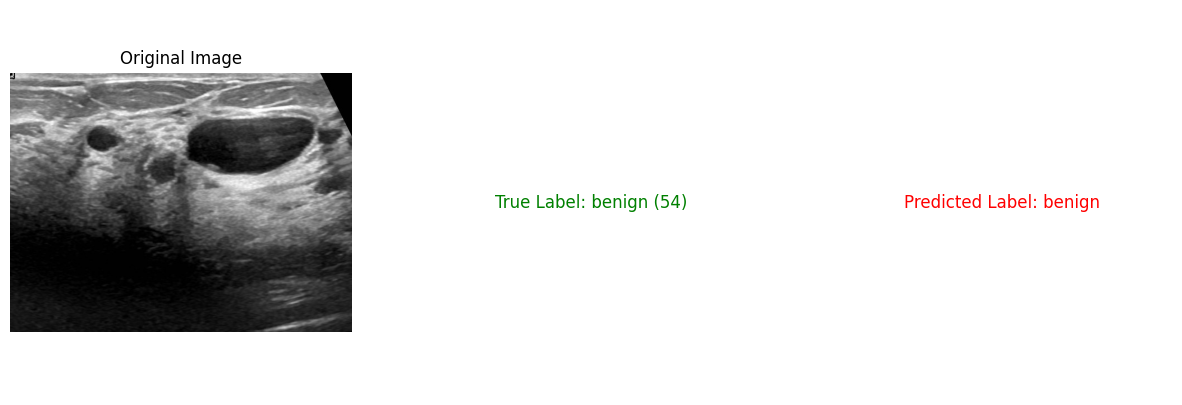

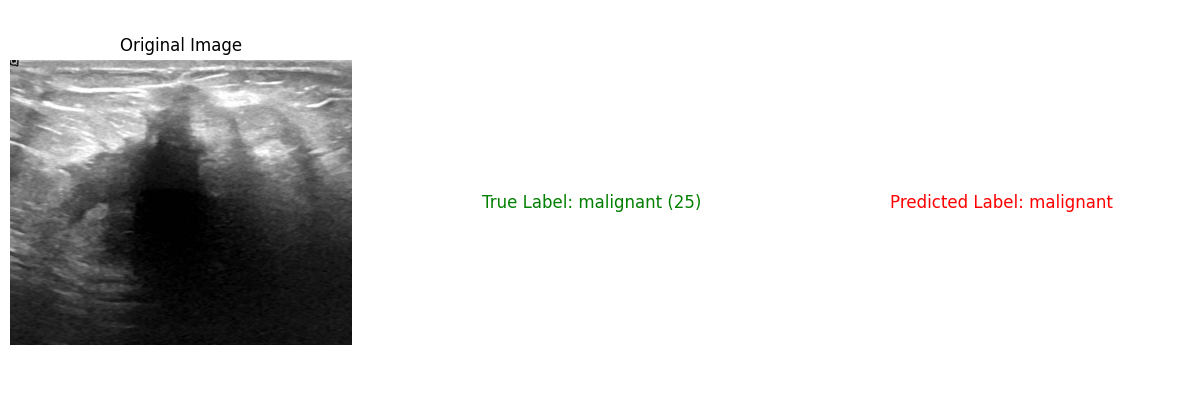

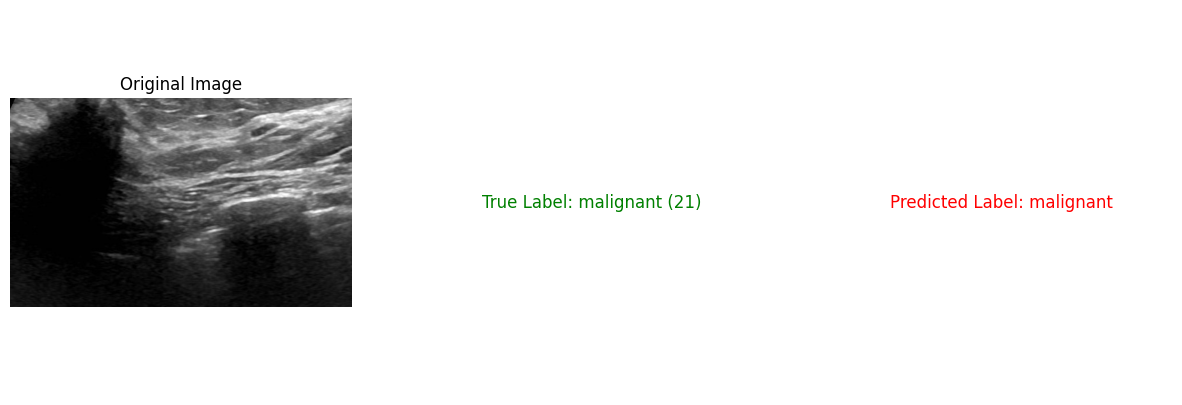

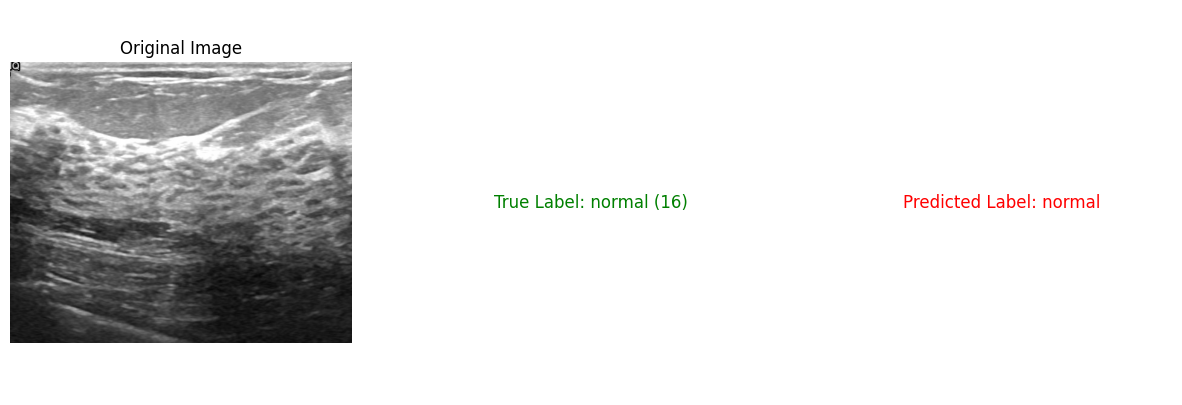

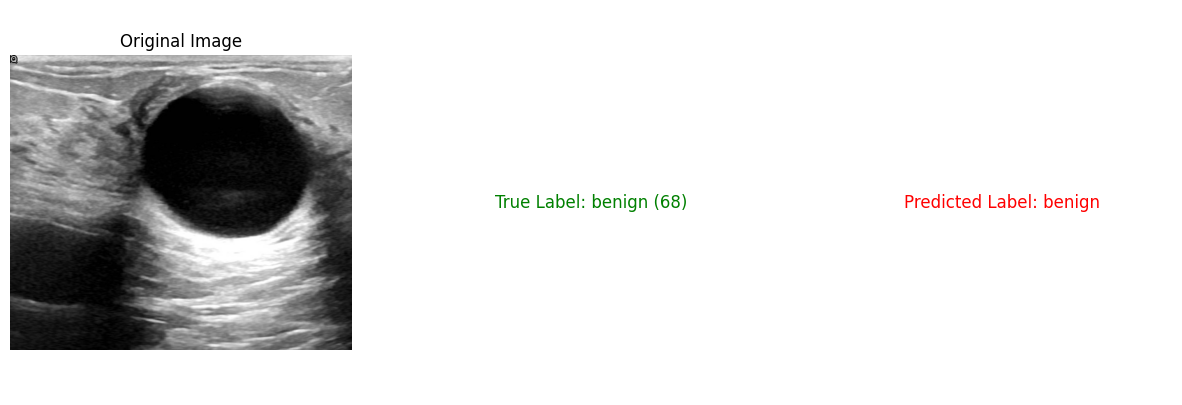

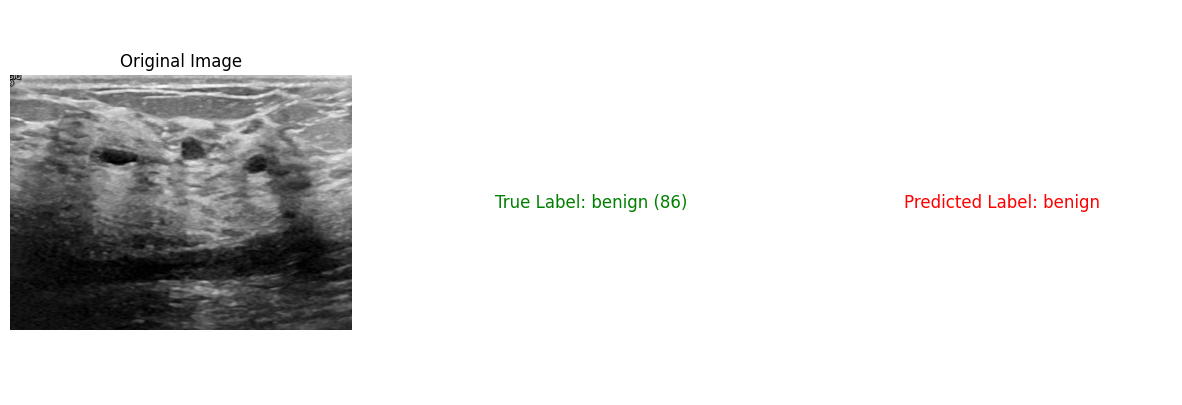

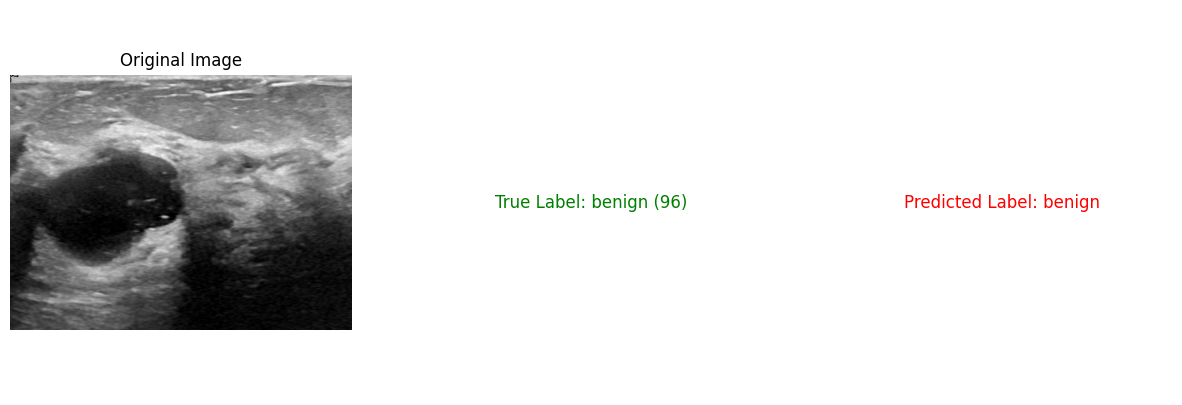

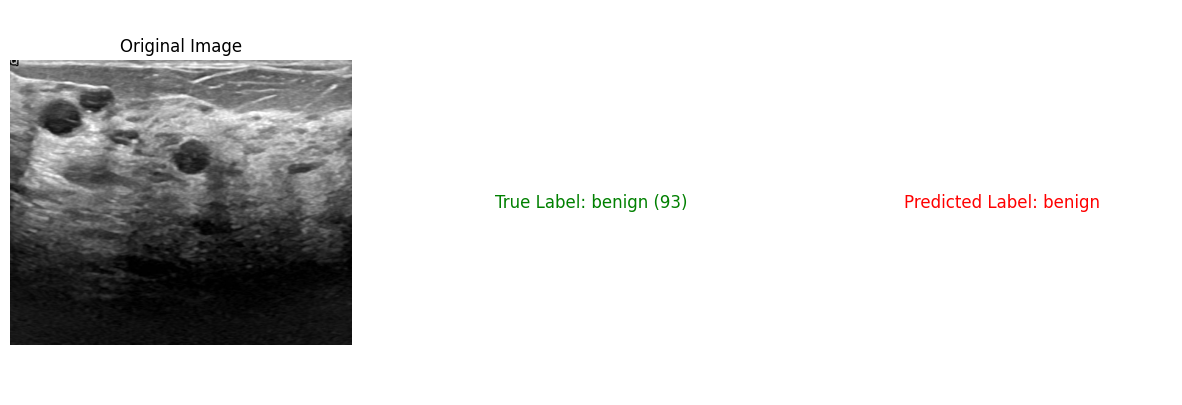

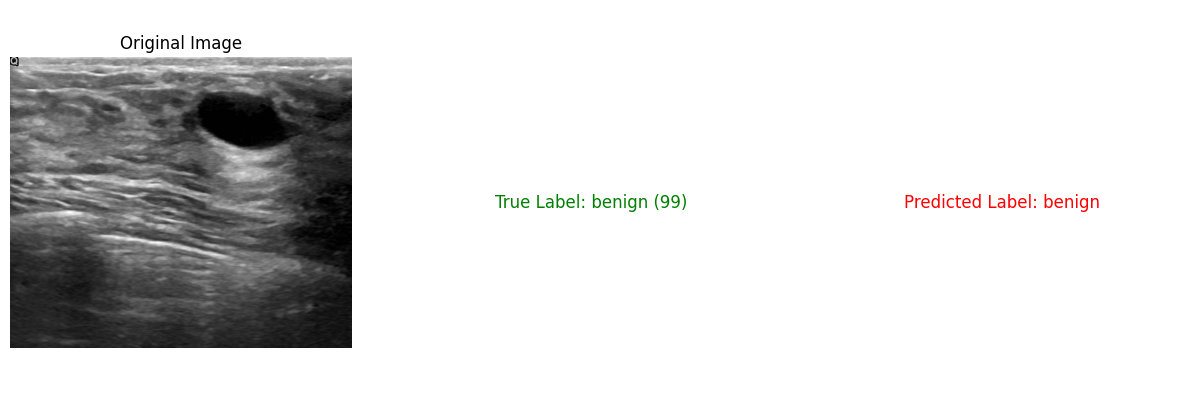

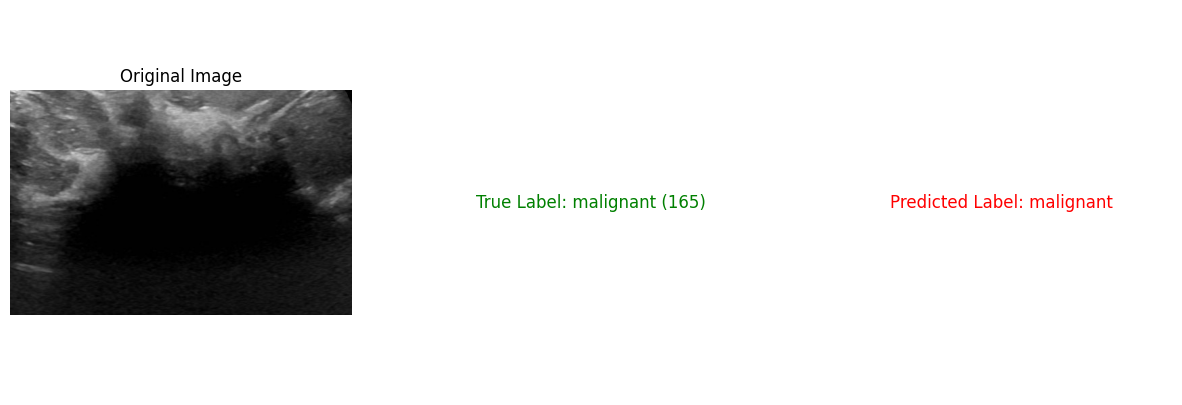

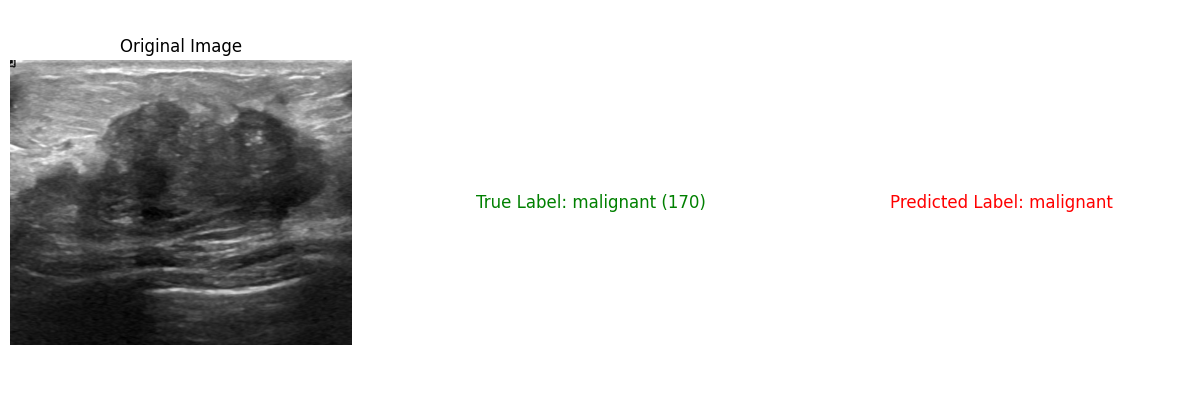

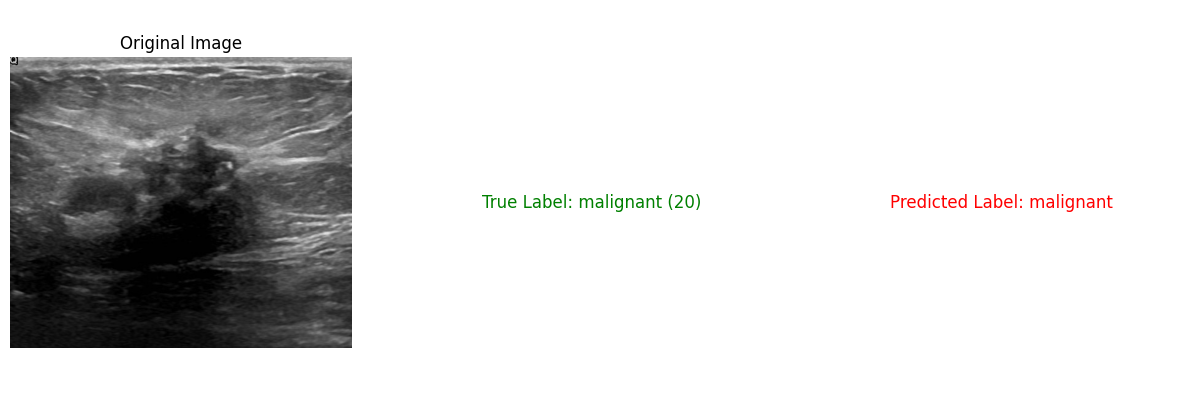

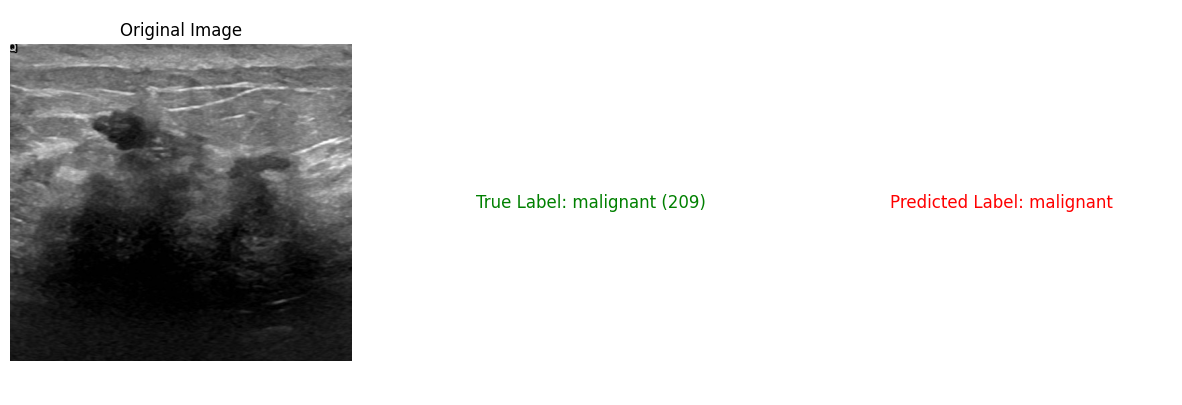

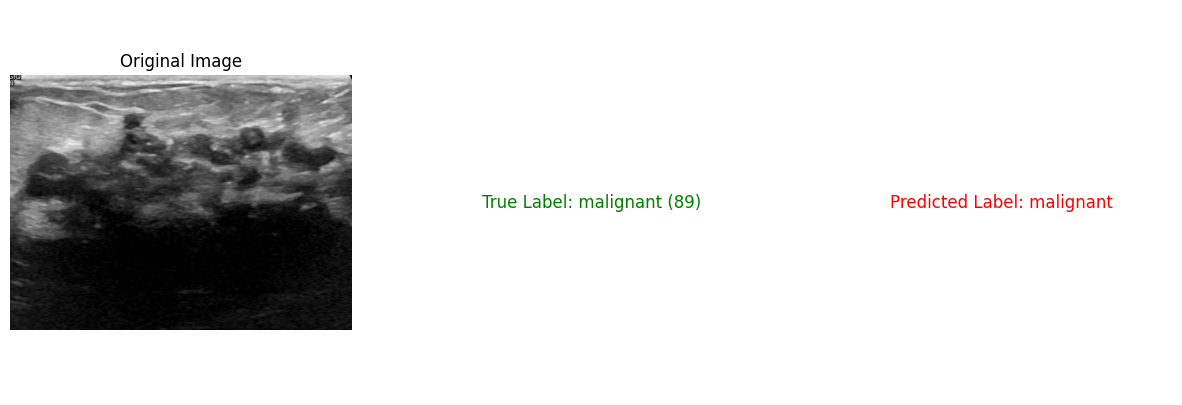

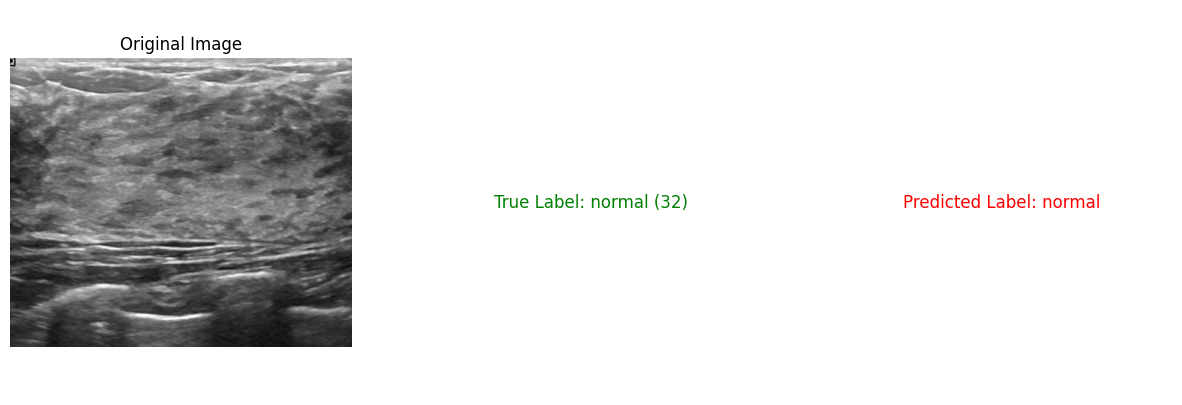

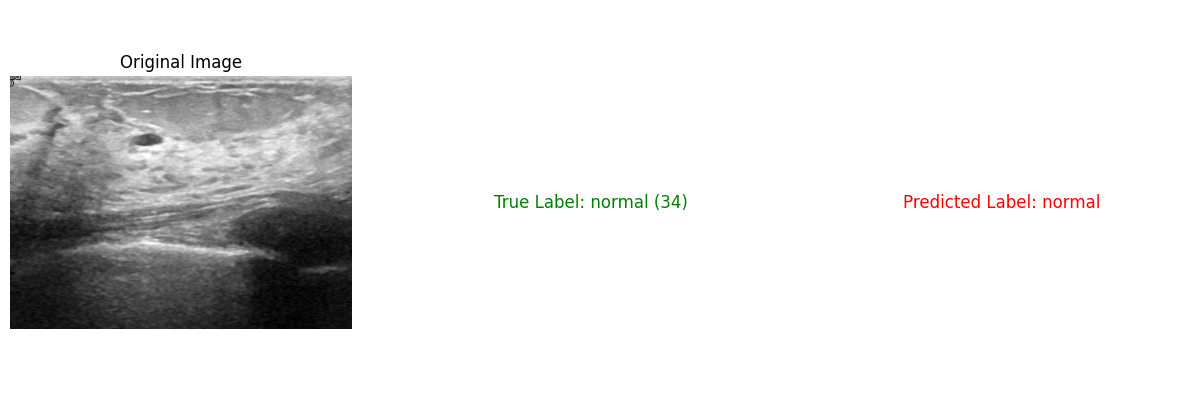

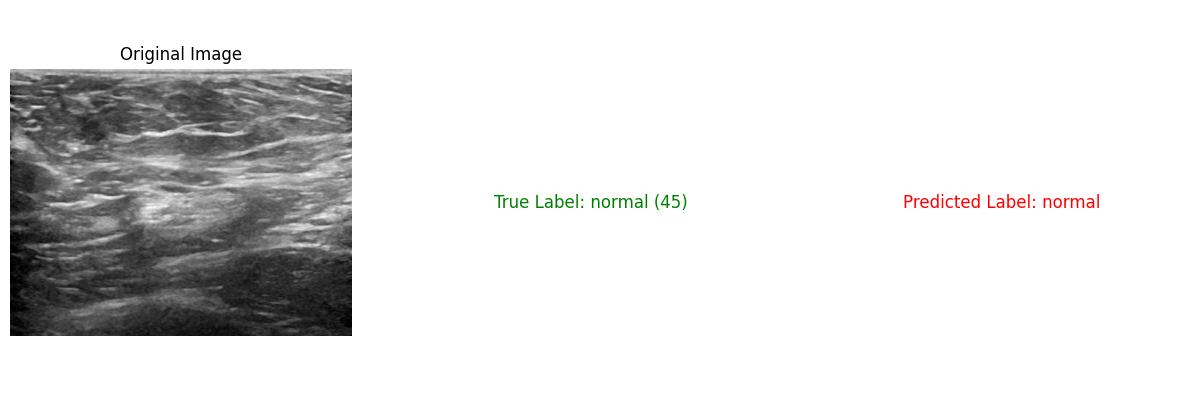

In [16]:
import os

directory_path = "/content/drive/MyDrive/CSE707/dataset/classify"
image_paths_to_classify = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(('.png', '.jpg', '.jpeg'))]

for image_path in image_paths_to_classify:
    # Load and preprocess the image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

    # Make the prediction
    net.eval()
    with torch.no_grad():
        output = net(input_tensor)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()

    # Map the predicted class to the corresponding label
    class_labels = trainloader.dataset.dataset.classes
    predicted_label = class_labels[predicted_class]

    # Extract the true label from the filename
    true_label = os.path.splitext(os.path.basename(image_path))[0]

    # Display the original image, true label, and predicted label
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(input_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Display the true label
    axes[1].text(0.5, 0.5, f"True Label: {true_label}", ha="center", va="center", fontsize=12, color="green")
    axes[1].axis("off")

    # Display the predicted label
    axes[2].text(0.5, 0.5, f"Predicted Label: {predicted_label}", ha="center", va="center", fontsize=12, color="red")
    axes[2].axis("off")

    plt.show()
